In [1]:
# read /data/csv/dependencies.csv

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display

df = pd.read_csv("data/csv/dependencies.csv")

display(df)

# df = df.head(1000)

G = nx.from_pandas_edgelist(
    df, source="dependency", target="package", create_using=nx.DiGraph()
)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print(
    "Number of weakly connected components:", nx.number_weakly_connected_components(G)
)
print(
    "Number of strongly connected components:",
    nx.number_strongly_connected_components(G),
)
print("Is directed:", nx.is_directed(G))

,package,dependency
0,libkate,libogg
1,libkate,libpng
2,git-revise,python@3.12
3,dps8m,libuv
4,proj,libtiff
...,...,...
13100,git-plus,python@3.12
13101,ocamlbuild,ocaml
13102,libpinyin,berkeley-db
13103,libpinyin,glib


Number of nodes: 4755
Number of edges: 13092
Number of weakly connected components: 33
Number of strongly connected components: 4755
Is directed: True


In [9]:
# Draw all weakly connected components
components = list(nx.weakly_connected_components(G))

plt.figure(figsize=(12, len(components) * 4))

<Figure size 1200x18000 with 0 Axes>

<Figure size 1200x18000 with 0 Axes>

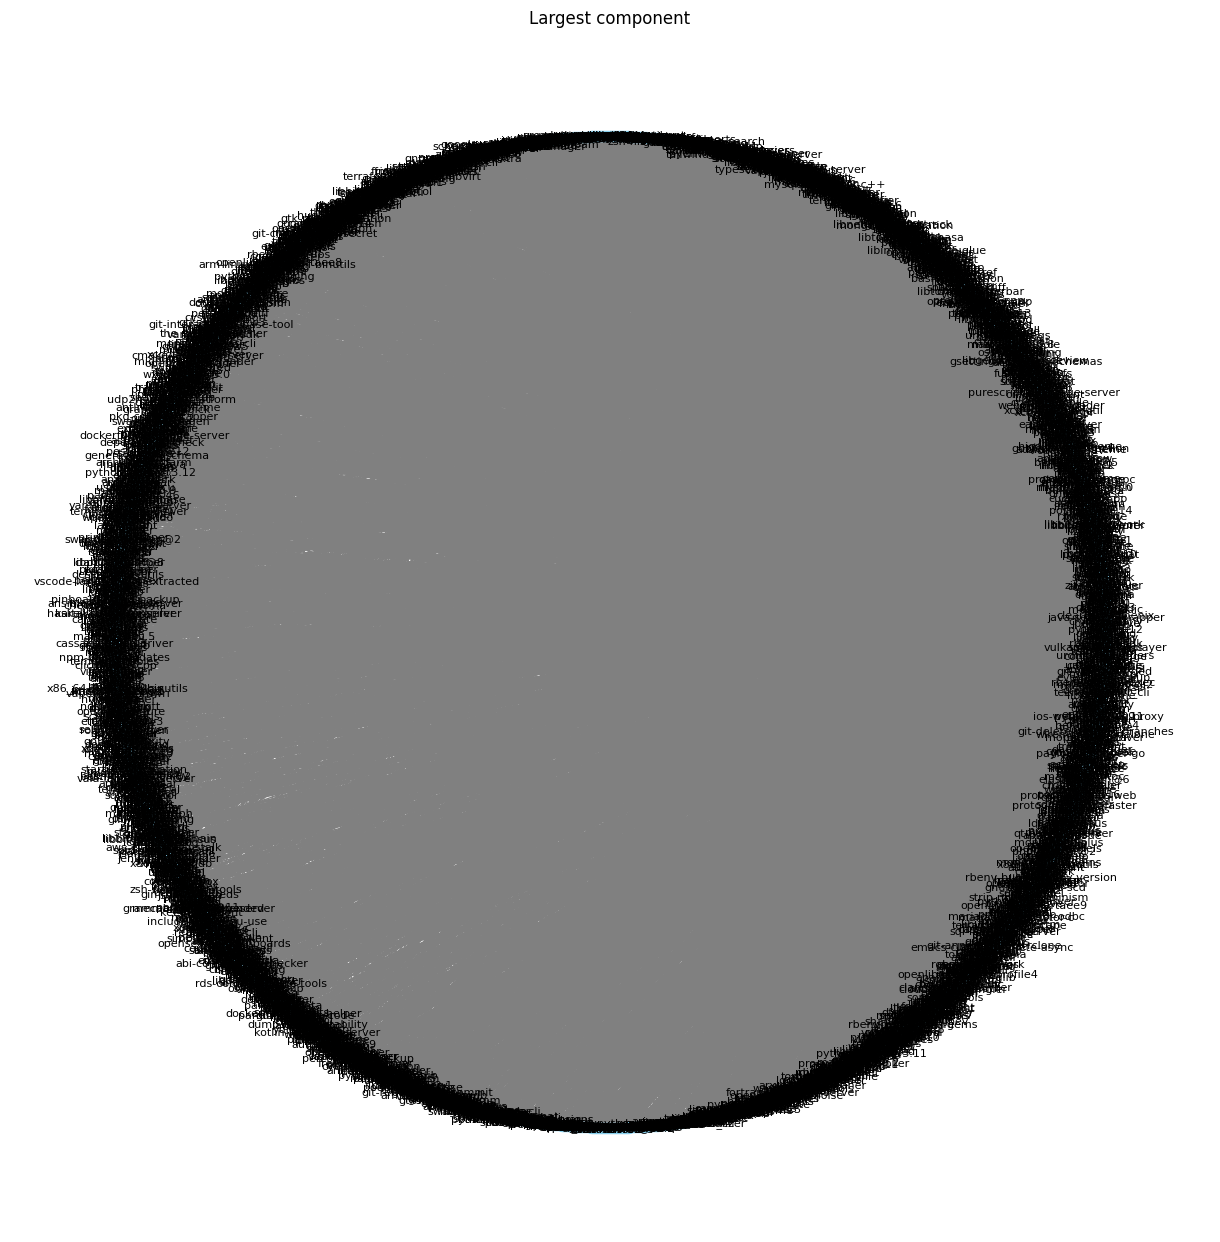

In [3]:
from networkx.drawing.nx_agraph import graphviz_layout

largest_component = max(components, key=len)

# Create a subgraph of the largest component
H = G.subgraph(largest_component)


# circular layout
pos = nx.circular_layout(H)

plt.figure(figsize=(12, 12))
nx.draw(
    H,
    pos,
    with_labels=True,
    node_size=50,
    node_color="skyblue",
    edge_color="gray",
    font_size=8,
)
plt.title("Largest component")
plt.axis("equal")
plt.show()

In [4]:
# Load package stats
stats = pd.read_csv(
    "data/csv/package_stats_with_contributors.csv",
    dtype={
        "install": "Int64",
        "install-on-request": "Int64",
        "contributors_count": "Int64",
    },
)
stats.loc[:, "repo_url"] = stats.loc[:, "repo_url"].fillna("")
stats.head()

,Unnamed: 0,package,repo_url,install,install-on-request,contributors_count
0,0,libkate,,1937,99,<NA>
1,1,bandwhich,,3498,3497,<NA>
2,2,git-revise,https://github.com/mystor/git-revise.git,325,325,19
3,3,mkvalidator,,93,93,<NA>
4,4,dps8m,https://gitlab.com/dps8m/dps8m.git,73,73,<NA>


In [5]:
# Associate package stats with each node.

nodes_to_remove = []  # We can't modify the graph during iteration
for node in G.nodes:
    if node not in stats["package"].values:
        print(f"{node} not found in stats")
        nodes_to_remove.append(node)
        continue
    stats_row = stats[stats["package"] == node].iloc[0]
    G.nodes[node]["install"] = stats_row["install"]
    G.nodes[node]["install_on_request"] = stats_row["install-on-request"]
    if not pd.isnull(stats_row["contributors_count"]):
        G.nodes[node]["contributors_count"] = stats_row["contributors_count"]

print(f"Removing {len(nodes_to_remove)} nodes")
G.remove_nodes_from(nodes_to_remove)

python not found in stats
cryptominisat not found in stats
libraqm not found in stats
pppd not found in stats
thrift@0.9 not found in stats
wiiuse not found in stats
libtar not found in stats
dtrx not found in stats
pygit2 not found in stats
cvs-fast-export not found in stats
liboauth not found in stats
wal2json not found in stats
fgbio not found in stats
resty not found in stats
hexer not found in stats
cf2tf not found in stats
bit not found in stats
ibex not found in stats
zboy not found in stats
gtksourceview3 not found in stats
openssl not found in stats
gypsy not found in stats
Removing 22 nodes


In [6]:
def find_dependents_to_infect(package, popularity_metric="contributors_count"):
    """Finds all direct and indirect dependents of this package, sorting by the given popularity metric.

    We assume here that the package with the smallest metric (by default number of contributors)  lacks maintainers, and is therefore vulnerable to an XZ-style attack.
    """

    dependents = set()
    node = G.nodes[package]
    if popularity_metric in node:
        dependents.add((package, node[popularity_metric]))

    for dependent in G.predecessors(package):
        dependents.update(find_dependents_to_infect(dependent, popularity_metric))

    return sorted(dependents, key=lambda x: x[1])

In [7]:
find_dependents_to_infect("ruby")

[('zlib', 45), ('ruby', 778)]

In [8]:
find_dependents_to_infect("ruby", "install_on_request")

[('gperf', 2760),
 ('libxcrypt', 3961),
 ('libffi', 89561),
 ('ca-certificates', 132784),
 ('libyaml', 181738),
 ('zlib', 196695),
 ('ruby', 320779),
 ('openssl@3', 638832)]